**How to identify position players on a given date?**

Problem:
<br>
In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

Strategy:
<br>
- Focus on features of the batter (e.g. historical batting average) and pitcher (e.g. historical ERA, WHIP) to predict whether the batter would output a hit (or HR, single, double, etc.) in a given batter-pitcher at-bat matchup.

- If you choose a given date (e.g. May 1), you know the starting pitcher a batter would face. Use statistical data to make a prediction on how well that player will do against the pitcher as a guide for a decision. If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. (Similar players can be found by using Erdos score.)

- How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

- Validation: Historical data

This notebook was created within my "insight" virtual environment.

**Inputs and outputs**

*Version 1:*
- Input: Two players under consideration for one position.
- Output: Player recommendation for that position with a predicted score.

*Version 2:*
- Input: A participant's player roster (e.g. 20 players)
- Output: A recommended lineup.

Order of features of product to incorporate: (still to be determined)

0.  Try a simple model where each at-bat batter-pitcher matchup is simply its own row and selected features are done.
1.	Roster’s “basic” baseball statistics from 2018 season? Or 50 games (including previous season) - (minimum viable product level)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season)
4.	Use of player similarity
5.	Weather, park effects, team defense, night/day, lineup order
6.	Limit to more recent performance (last 7 games)
7.	Computer vision?

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/



EDA, do HR over time and by date for each player

Use batted ball characteristics as a feature of player and pitcher (launch angle average, launch speed average)




**Product pitch**

I'm creating a fantasy baseball application that suggests players on a given day. Fantasy baseball has over 11 million participants with the winners of leagues collecting entry fees and host platforms receiving a commission. The projected market for fantasy baseball in 2020 is over 8 billion dollars. A participant's success depends in part on daily player selection. For player selection, participants must rely on their own research or use a site's recommendation, which uses black-box algorithms behind pay walls. I'm developing an alternative algorithm to assist in player selection to save participants time and expose the important features in player performance prediction.

# Ideas

- Predicting the next pitch, based on count

- Will hit happen based on pitch count

- Or use all info for at-bat and then do backwards selection 

- 2018 season as true talent average, then update with each at bat
- Use Bayesian 

- EDA  - plot someone's hits over game-dates as a time series

- Look at the player's last 100 hits 

**Motivation: Learning analytics requries some skills I can develop here**

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [2]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [622]:
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

<IPython.core.display.Javascript object>

In [3]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [4]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Build a database

In [7]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [8]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

In [9]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


<IPython.core.display.Javascript object>

## Statcast data to database

In [ ]:
# This is done, but note it's out of order

# date_list = [
#     ("2019-03-20", "2019-09-29"),
#     ("2018-03-29", "2018-10-01"),
#     ("2017-04-02", "2017-10-01"),
# ]

# Above gave **2,174,906** pitch-by-pitch results in the database

#     ("2016-04-03", "2016-10-02"),   # didn't get
#     ("2015-04-05", "2015-10-04"),   # didn't get 


# for i, date_pair in enumerate(date_list):
#     if i < 1:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="replace")
#         print(date_pair, "replace mode")
#     else:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="append")
#         print(date_pair, "append mode")

In [11]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

See other notebook for more info



In [ ]:
# Get player id
sql_query = """
SELECT * FROM player_id;
"""

df_player_id = pd.read_sql_query(sql_query, con)

# Predicting if an at-bat will be a 1 (or higher probability)

## Input batter and date

In [406]:
# Make a query to get player - batter matchup

# Enter key_mlbam (Manny Machado shown below)
# pid_of_interest = 592518

# Enter key_mlbam (Ty France shown below)
pid_of_interest = 664034

# Enter key_mlbam (Manuel Margot shown below)
pid_of_interest = 622534

date_of_interest = "'2019-09-09'"  # Note internal single quotes

sql_query = (
    """
SELECT * FROM statcast 
JOIN player_id ON statcast.batter=player_id.key_mlbam 
WHERE statcast.batter= 
"""
    + str(pid_of_interest)
    + """
AND statcast.game_date<=
"""
    + str(date_of_interest)
    + """
AND statcast.events IS NOT NULL 
ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up 
LIMIT 501;
"""
)


# "Sample query"

# pitchers and batters
# sql_query = """
# (SELECT * FROM statcast WHERE "game_date" > '2019-01-01'
# AND "events" IS NOT NULL);
# """

df_sc_events = pd.read_sql_query(sql_query, con)
df_sc_events.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

<IPython.core.display.Javascript object>

## Contingencies

1. What if player has day off? or no game is scheduled?
2. What if player or pitcher doesn't have minimum nback at-bats?
3. What if player doesn't have minimum nback at-bats against same or opposite handedness?

**Quora answer on number of plate appearances**
https://www.quora.com/How-many-at-bats-does-the-average-MLB-player-go-through-per-year

One direction to go with is how many PA wpild a player accumulate if theu were to play every day, and not rest. That would be around 725. Though that total is not really an average as few players exceed such a total each year.

A second number would be how many plate appearances bases on normal rest during a season if a player never was injured, about 145-150 games for position players other then the catcher and 110 to 115 for catchers. Those totals would be around 650 and 450 respectively.

Yet another way to answer this would be the number of PA by all position players on a roster that were supposed to be starters, but may receive less playing time due to injury or a team developing, trading for or discovering a better player. That would probably be closer to 400.

You could also thing about all position players on a team including bench players, if we include them our total now is closer to 200-250.

Yet another way to look at this is to include all players on the roster including pitcher who may notbat intentionally. Include them and tour total is closer to 100-120.

In [407]:
df_sc_events.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FS,2019-09-09,87.4,-2.5376,6.0542,James Norwood,622534.0,656803.0,strikeout,swinging_strike,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
1,FT,2019-09-08,94.6,-1.7748,5.7453,Jairo Diaz,622534.0,545064.0,field_out,hit_into_play,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
2,SI,2019-09-07,93.7,-2.4845,5.5313,Wes Parsons,622534.0,641149.0,force_out,hit_into_play,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
3,FF,2019-09-06,99.2,-1.7824,5.6267,Carlos Estevez,622534.0,608032.0,strikeout,foul_tip,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
4,FF,2019-09-04,95.4,-2.2010,6.0858,Yoan Lopez,622534.0,661255.0,field_out,hit_into_play,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0


<IPython.core.display.Javascript object>

In [408]:
df_sc_events.shape

(501, 97)

<IPython.core.display.Javascript object>

In [409]:
df_sc_events.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FS,2019-09-09,87.4,-2.5376,6.0542,James Norwood,622534.0,656803.0,strikeout,swinging_strike,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
1,FT,2019-09-08,94.6,-1.7748,5.7453,Jairo Diaz,622534.0,545064.0,field_out,hit_into_play,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
2,SI,2019-09-07,93.7,-2.4845,5.5313,Wes Parsons,622534.0,641149.0,force_out,hit_into_play,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
3,FF,2019-09-06,99.2,-1.7824,5.6267,Carlos Estevez,622534.0,608032.0,strikeout,foul_tip,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0
4,FF,2019-09-04,95.4,-2.2010,6.0858,Yoan Lopez,622534.0,661255.0,field_out,hit_into_play,...,Standard,Standard,margot,manuel,622534,margm001,margoma01,14712,2016.0,2019.0


<IPython.core.display.Javascript object>

In [410]:
# Encode on-base events, including walks
ob_list = ["walk", "single", "double", "triple", "home_run"]
df_sc_events["event_code"] = 0
df_sc_events.loc[df_sc_events["events"].isin(ob_list), "event_code"] = 1

<IPython.core.display.Javascript object>

In [411]:
n_back_PA = 100

# Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak
df_sc_events["num_events_sum_nback"] = df_sc_events["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]

# Percent of on-base events (overall)
df_sc_events["prop_events_nback"] = df_sc_events["num_events_sum_nback"] / n_back_PA

# Percent of on-base events against handedness of pitcher
for i in df_sc_events.index:
    p_throws = df_sc_events["p_throws"].iloc[i]
    df_sc_events_pt_throw = df_sc_events[df_sc_events["p_throws"] == batter_stance]
    n_pt_events = df_sc_events_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
    df_sc_events.loc[i, "num_events_sum_nback_pt"] = n_pt_events
    df_sc_events.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA
    
# df_sc_events.loc[: n_back_PA + 1, "event_code"]


<IPython.core.display.Javascript object>

In [412]:
df_sc_events.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,event_code,num_events_sum_nback,prop_events_nback,num_events_sum_nback_pt,prop_events_sum_nback_pt
0,FS,2019-09-09,87.4,-2.5376,6.0542,James Norwood,622534.0,656803.0,strikeout,swinging_strike,...,margm001,margoma01,14712,2016.0,2019.0,0,27.0,0.27,23.0,0.23
1,FT,2019-09-08,94.6,-1.7748,5.7453,Jairo Diaz,622534.0,545064.0,field_out,hit_into_play,...,margm001,margoma01,14712,2016.0,2019.0,0,27.0,0.27,23.0,0.23
2,SI,2019-09-07,93.7,-2.4845,5.5313,Wes Parsons,622534.0,641149.0,force_out,hit_into_play,...,margm001,margoma01,14712,2016.0,2019.0,0,27.0,0.27,23.0,0.23
3,FF,2019-09-06,99.2,-1.7824,5.6267,Carlos Estevez,622534.0,608032.0,strikeout,foul_tip,...,margm001,margoma01,14712,2016.0,2019.0,0,28.0,0.28,23.0,0.23
4,FF,2019-09-04,95.4,-2.2010,6.0858,Yoan Lopez,622534.0,661255.0,field_out,hit_into_play,...,margm001,margoma01,14712,2016.0,2019.0,0,28.0,0.28,23.0,0.23


<IPython.core.display.Javascript object>

In [388]:
df_sc_events.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'key_retro', 'key_bbref', 'key_fangraphs', 'mlb_played_first',
       'mlb_played_last', 'event_code', 'num_events_sum_nback',
       'prop_events_nback', 'num_events_sum_nback_pt',
       'prop_events_sum_nback_pt'],
      dtype='object', length=102)

<IPython.core.display.Javascript object>

In [413]:
col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]

m_size = 200
df_sc_events_4model = df_sc_events[col4model].copy()
df_sc_events_4model_overall = df_sc_events_4model.loc[:m_size]

<IPython.core.display.Javascript object>

In [451]:
df_sc_events_4model_overall.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,0,1,0.27,0.23
1,0,1,0.27,0.23
2,0,1,0.27,0.23
3,0,1,0.28,0.23
4,0,1,0.28,0.23


<IPython.core.display.Javascript object>

In [450]:
df_sc_events_4model_overall.shape

(201, 4)

<IPython.core.display.Javascript object>

## EDA

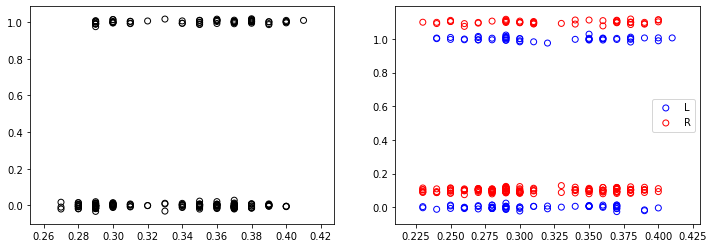

<IPython.core.display.Javascript object>

In [415]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(
    df_sc_events_4model_overall["prop_events_nback"],
    df_sc_events_4model_overall["event_code"]
    + np.random.normal(0, 0.01, len(df_sc_events_4model_overall)),
    facecolors="none",
    edgecolors="black",
)

for hand in ["L", "R"]:
    if hand == "L":
        df_temp = df_sc_events_4model[df_sc_events_4model["p_throws"] == hand].iloc[
            :m_size, :
        ]
        ax2.scatter(
            df_temp["prop_events_nback"],
            df_temp["event_code"] + np.random.normal(0, 0.01, len(df_temp)),
            facecolors="none",
            edgecolors="blue",
            label=hand,
        )
    else:
        df_temp = df_sc_events_4model[df_sc_events_4model["p_throws"] == hand].iloc[
            :m_size, :
        ]
        ax2.scatter(
            df_temp["prop_events_nback"],
            df_temp["event_code"] + 0.1 + np.random.normal(0, 0.01, len(df_temp)),
            facecolors="none",
            edgecolors="red",
            label=hand,
        )
ax2.legend()

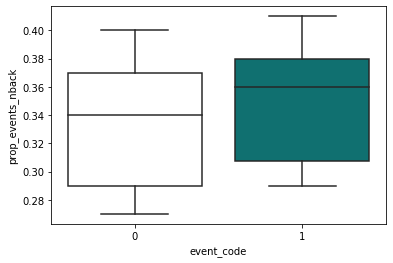

<IPython.core.display.Javascript object>

In [453]:
f, ax1 = plt.subplots()

sns.boxplot(
    x="event_code",
    y="prop_events_nback",
    data=df_sc_events_4model_overall,
    palette=["w", "teal"],
    order=[0, 1],
    ax=ax1,
)

In [461]:
df_sc_events_4model_overall.head()

#
# df_sc_events_4model_overall["prop_events_nback"]

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,0,1,0.27,0.23
1,0,1,0.27,0.23
2,0,1,0.27,0.23
3,0,1,0.28,0.23
4,0,1,0.28,0.23


<IPython.core.display.Javascript object>

In [468]:
groupA1_vals = df_sc_events_4model_overall.loc[
    df_sc_events_4model_overall["event_code"] == 0, "prop_events_nback"
]
groupA2_vals = df_sc_events_4model_overall.loc[
    df_sc_events_4model_overall["event_code"] == 1, "prop_events_nback"
]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]

print(mw_p_A, ttest_p_A)

0.0024042283217230436 0.010034862058101928


<IPython.core.display.Javascript object>

In [417]:
df_sc_events_4model_overall["p_throws"] = (
    df_sc_events_4model_overall["p_throws"].replace({"L": 0, "R": 1}).copy()
)

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

In [418]:
df_sc_events_4model_overall.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,0,1,0.27,0.23
1,0,1,0.27,0.23
2,0,1,0.27,0.23
3,0,1,0.28,0.23
4,0,1,0.28,0.23


<IPython.core.display.Javascript object>

In [419]:
# Aggregate per game

df_sc_events_4model_overall_bydate = df_sc_events_4model_overall.copy()

df_sc_events_4model_overall_bydate["game_date"] = df_sc_events.loc[:m_size, "game_date"]

<IPython.core.display.Javascript object>

In [420]:
df_sc_events_4model_overall_bydate.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,game_date
0,0,1,0.27,0.23,2019-09-09
1,0,1,0.27,0.23,2019-09-08
2,0,1,0.27,0.23,2019-09-07
3,0,1,0.28,0.23,2019-09-06
4,0,1,0.28,0.23,2019-09-04


<IPython.core.display.Javascript object>

In [421]:
df_sc_events_4model_overall_bydate.groupby(["game_date", "p_throws"])

<IPython.core.display.Javascript object>

In [439]:
df_temp_sum = (
    df_sc_events_4model_overall_bydate.groupby(["game_date"])
    .sum()
    .sort_values(by="game_date", ascending=False)
)

df_temp_count = (
    df_sc_events_4model_overall_bydate.groupby(["game_date"])
    .count()
    .sort_values(by="game_date", ascending=False)
)

df_temp_mean = (
    df_sc_events_4model_overall_bydate.groupby(["game_date", "p_throws"])
    .mean()
    .sort_values(by="game_date", ascending=False)
)

# df_temp = (
#     df_sc_events_4model_overall_bydate.groupby(["game_date", "p_throws"])
#     .sum()
#     .sort_values(by="game_date", ascending=False)
# )



<IPython.core.display.Javascript object>

In [440]:
df_temp_mean

,,event_code,prop_events_nback,prop_events_sum_nback_pt
game_date,p_throws,,,
2019-09-09,1,0.000000,0.270000,0.230000
2019-09-08,1,0.000000,0.270000,0.230000
2019-09-07,1,0.000000,0.270000,0.230000
2019-09-06,1,0.000000,0.280000,0.230000
2019-09-04,1,0.000000,0.286667,0.233333
...,...,...,...,...
2019-07-02,0,1.000000,0.290000,0.240000
2019-07-01,1,0.333333,0.290000,0.250000
2019-06-30,1,0.000000,0.292500,0.257500


<IPython.core.display.Javascript object>

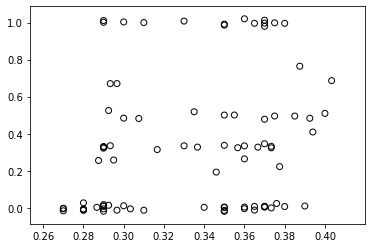

<IPython.core.display.Javascript object>

In [442]:
f, ax1 = plt.subplots()

ax1.scatter(
    df_temp_mean["prop_events_nback"],
    df_temp_mean["event_code"]
    + np.random.normal(0, 0.01, len(df_temp_mean)),
    facecolors="none",
    edgecolors="black",
)



In [445]:
df_temp_mean_hand.shape

(27, 3)

<IPython.core.display.Javascript object>

In [447]:
df_temp_mean_hand["prop_events_sum_nback_pt"].tolist()

[0.25,
 0.25,
 0.2475,
 0.28,
 0.29,
 0.3,
 0.28500000000000003,
 0.29,
 0.28,
 0.29,
 0.27,
 0.27,
 0.2733333333333334,
 0.26,
 0.26,
 0.26,
 0.23,
 0.21666666666666667,
 0.2225,
 0.235,
 0.23,
 0.22,
 0.235,
 0.2333333333333333,
 0.24,
 0.24,
 0.25]

<IPython.core.display.Javascript object>

0 (27, 3)
1 (56, 3)


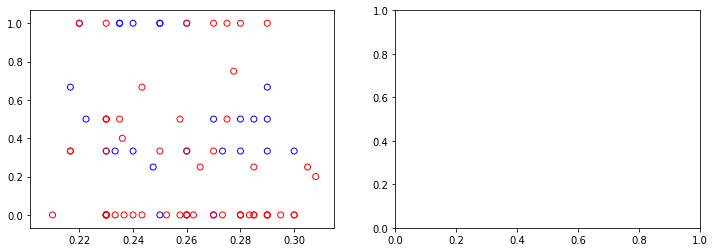

<IPython.core.display.Javascript object>

In [449]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

col_list = ['blue', 'red']

for hand in [0, 1]:
    df_temp_mean_hand = df_temp_mean.loc[df_temp_mean.index.get_level_values(1)==hand, :]
    print(hand, df_temp_mean_hand.shape)
    
    x_vals = df_temp_mean_hand["prop_events_sum_nback_pt"].tolist()
    y_vals = df_temp_mean_hand["event_code"].tolist()
    
    ax1.scatter(
    x_vals,
    y_vals,
    #+ np.random.normal(0, 0.001, len(df_temp_mean_hand)),
    facecolors="none",
    edgecolors=col_list[hand])
    
    # trend line
#     z = np.polyfit(x_vals, y_vals, 1)
#     p = np.poly1d(z)
#     ax1.plot(x_vals, p(y_vals),"--")
    

# ax1.scatter(
#     df_temp_mean["prop_events_nback"],
#     df_temp_mean["event_code"]
#     + np.random.normal(0, 0.1, len(df_temp_mean)),
#     facecolors="none",
#     edgecolors="black",
# )


## Other ideas




- Look at probabilities, instead of looking for 1 (done - not strong)
- Aggregate per game (potentially something there - not sure)
- Look at Ty France
- Add in pitcher info 
- See what pitches they're hitting, then see how that matches with pitchers 
- Remember that ultimately, we want to see that we're picking the right player - someone who has a higher probability overall will be better choice


**Motivation: Learning analytics requries some skills I can develop here**

## Logistic regression

In [543]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

<IPython.core.display.Javascript object>

In [318]:
y = df_sc_events_4model_overall["event_code"]
X = df_sc_events_4model_overall.iloc[:, 1::]

<IPython.core.display.Javascript object>

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<IPython.core.display.Javascript object>

In [320]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 3) (31, 3) (70,) (31,)


<IPython.core.display.Javascript object>

In [321]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [322]:
y_pred = log_reg.predict(X_test)

<IPython.core.display.Javascript object>

In [323]:
y_prob = log_reg.predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

In [471]:
df_temp = pd.DataFrame({"test": y_test, "pred": y_pred, "prob": y_prob})
df_temp.head()

,test,pred,prob
5,0,0,0.335620
55,0,0,0.335580
31,0,0,0.336508
70,1,0,0.335039
24,0,0,0.336277


<IPython.core.display.Javascript object>

In [325]:
df_temp["pred"].sum()

0

<IPython.core.display.Javascript object>

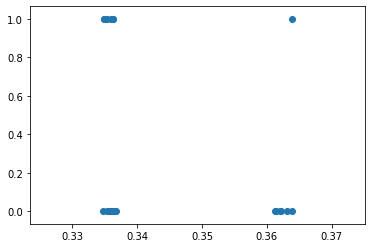

<IPython.core.display.Javascript object>

In [326]:
f, ax1 = plt.subplots()
ax1.scatter(df_temp["prob"], df_temp["test"])

In [293]:
df_temp["pred"].sum()

0

<IPython.core.display.Javascript object>

In [227]:
df_sc_events.loc[
    0:50,
    [
        "event_code",
        "p_throws",
        "num_events_sum_nback",
        "prop_events_nback",
        "num_events_sum_nback_pt",
        "prop_events_sum_nback_pt",
    ],
]

,event_code,p_throws,num_events_sum_nback,prop_events_nback,num_events_sum_nback_pt,prop_events_sum_nback_pt
0,1,R,5.0,0.5,5.0,0.5
1,1,R,4.0,0.4,4.0,0.4
2,0,R,3.0,0.3,3.0,0.3
3,1,R,3.0,0.3,3.0,0.3
4,1,R,2.0,0.2,2.0,0.2
5,0,R,1.0,0.1,1.0,0.1
6,0,R,1.0,0.1,1.0,0.1
7,0,R,2.0,0.2,2.0,0.2
8,0,R,3.0,0.3,3.0,0.3
9,1,R,3.0,0.3,3.0,0.3


<IPython.core.display.Javascript object>

In [218]:
for i in df_sc_events.index:
    p_throws = df_sc_events["p_throws"].iloc[i]
    df_sc_events_pt_throw = df_sc_events[df_sc_events["p_throws"] == batter_stance]
    n_pt_events = df_sc_events_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
    df_sc_events.loc[i, "num_events_sum_nback_pt"] = n_pt_events
    df_sc_events.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA
#     print(
#         i,
#         df_sc_events_pt_throw["game_date"].iloc[i],
#         df_sc_events["num_events_sum_nback"].iloc[i],
#         df_sc_events_pt_throw["event_code"].iloc[i],
#         "end: ",
#         df_sc_events_pt_throw["event_code"].iloc[i + n_back_PA + 1],
#         p_throws,
#         n_pt_events,
#     )

0 2019-09-09 00:00:00 33.0 1 end:  0 R 29
1 2019-09-09 00:00:00 32.0 1 end:  0 R 29
2 2019-09-09 00:00:00 32.0 0 end:  0 R 28
3 2019-09-08 00:00:00 32.0 1 end:  1 R 28
4 2019-09-08 00:00:00 31.0 1 end:  0 R 27
5 2019-09-08 00:00:00 30.0 0 end:  0 R 27
6 2019-09-08 00:00:00 30.0 0 end:  0 R 27
7 2019-09-08 00:00:00 30.0 0 end:  0 R 27
8 2019-09-07 00:00:00 31.0 0 end:  0 R 27
9 2019-09-07 00:00:00 31.0 1 end:  0 R 27
10 2019-09-07 00:00:00 31.0 0 end:  0 R 26
11 2019-09-07 00:00:00 31.0 0 end:  1 R 26
12 2019-09-06 00:00:00 31.0 0 end:  1 R 26
13 2019-09-06 00:00:00 31.0 0 end:  1 R 27
14 2019-09-06 00:00:00 31.0 0 end:  1 R 28
15 2019-09-06 00:00:00 31.0 0 end:  1 R 29
16 2019-09-04 00:00:00 31.0 1 end:  0 R 30
17 2019-09-04 00:00:00 30.0 1 end:  0 R 30
18 2019-09-04 00:00:00 29.0 0 end:  0 R 29
19 2019-09-04 00:00:00 29.0 0 end:  1 R 29
20 2019-09-03 00:00:00 29.0 0 end:  0 R 29
21 2019-09-03 00:00:00 29.0 0 end:  0 R 30
22 2019-09-03 00:00:00 29.0 0 end:  0 R 30
23 2019-09-03 00:00:0

204 2019-06-22 00:00:00 34.0 1 end:  1 R 36
205 2019-06-22 00:00:00 33.0 0 end:  0 L 35
206 2019-06-21 00:00:00 33.0 1 end:  0 R 36
207 2019-06-21 00:00:00 34.0 0 end:  0 R 35
208 2019-06-21 00:00:00 35.0 1 end:  0 R 35
209 2019-06-21 00:00:00 34.0 0 end:  0 R 34
210 2019-06-19 00:00:00 35.0 0 end:  0 R 34
211 2019-06-19 00:00:00 36.0 1 end:  0 R 34
212 2019-06-19 00:00:00 37.0 0 end:  0 R 33
213 2019-06-19 00:00:00 37.0 1 end:  1 R 33
214 2019-06-19 00:00:00 37.0 0 end:  1 R 32
215 2019-06-18 00:00:00 37.0 0 end:  0 R 33
216 2019-06-18 00:00:00 37.0 1 end:  0 R 34
217 2019-06-18 00:00:00 38.0 1 end:  0 R 33
218 2019-06-18 00:00:00 38.0 0 end:  0 R 32
219 2019-06-17 00:00:00 38.0 0 end:  1 R 32
220 2019-06-17 00:00:00 38.0 0 end:  1 R 32
221 2019-06-17 00:00:00 37.0 1 end:  0 L 33
222 2019-06-17 00:00:00 37.0 1 end:  1 L 33
223 2019-06-16 00:00:00 37.0 1 end:  0 L 32
224 2019-06-16 00:00:00 37.0 0 end:  1 L 32
225 2019-06-16 00:00:00 38.0 0 end:  1 R 32
226 2019-06-16 00:00:00 38.0 0 e

IndexError: single positional indexer is out-of-bounds

<IPython.core.display.Javascript object>

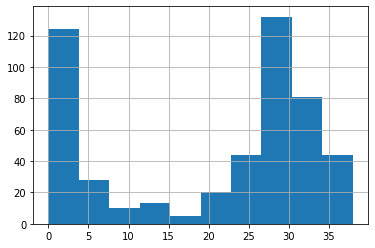

<IPython.core.display.Javascript object>

In [214]:
df_sc_events.loc[:, "num_events_sum_nback_pt"].hist()

In [194]:
for i in df_sc_events.index:
    batter_stance = df_sc_events["stand"].iloc[i]
    df_sc_events_cp_throw = df_sc_events[df_sc_events["p_throws"] == batter_stance]
    n_cp_events = df_sc_events_cp_throw["event_code"].iloc[i : i + 100].sum()
    print(
        i,
        df_sc_events_cp_throw["game_date"].iloc[i],
        df_sc_events_cp_throw["event_code"].iloc[i],
        p_throw,
        n_cp_events,
    )

#     print(df_sc_events_cp_throw["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1].iloc[
#     0:100)
# ]

0 2019-09-09 00:00:00 1 R 29
1 2019-09-09 00:00:00 1 R 29
2 2019-09-09 00:00:00 0 R 28
3 2019-09-08 00:00:00 1 R 28
4 2019-09-08 00:00:00 1 R 27
5 2019-09-08 00:00:00 0 R 27
6 2019-09-08 00:00:00 0 R 27
7 2019-09-08 00:00:00 0 R 27
8 2019-09-07 00:00:00 0 R 27
9 2019-09-07 00:00:00 1 R 27
10 2019-09-07 00:00:00 0 R 26
11 2019-09-07 00:00:00 0 R 26
12 2019-09-06 00:00:00 0 R 26
13 2019-09-06 00:00:00 0 R 27
14 2019-09-06 00:00:00 0 R 28
15 2019-09-06 00:00:00 0 R 29
16 2019-09-04 00:00:00 1 R 30
17 2019-09-04 00:00:00 1 R 30
18 2019-09-04 00:00:00 0 R 29
19 2019-09-04 00:00:00 0 R 29
20 2019-09-03 00:00:00 0 R 29
21 2019-09-03 00:00:00 0 R 30
22 2019-09-03 00:00:00 0 R 30
23 2019-09-03 00:00:00 0 R 30
24 2019-09-02 00:00:00 0 R 30
25 2019-09-02 00:00:00 1 R 30
26 2019-09-02 00:00:00 0 R 29
27 2019-09-02 00:00:00 0 R 30
28 2019-09-01 00:00:00 1 R 31
29 2019-09-01 00:00:00 0 R 30
30 2019-09-01 00:00:00 0 R 31
31 2019-09-01 00:00:00 0 R 32
32 2019-08-31 00:00:00 0 R 32
33 2019-08-31 00:00:

276 2019-06-01 00:00:00 0 R 26
277 2019-05-31 00:00:00 0 R 27
278 2019-05-31 00:00:00 0 R 27
279 2019-05-29 00:00:00 0 R 27
280 2019-05-28 00:00:00 0 R 27
281 2019-05-28 00:00:00 1 R 27
282 2019-05-28 00:00:00 0 R 26
283 2019-05-28 00:00:00 0 R 27
284 2019-05-28 00:00:00 1 R 28
285 2019-05-27 00:00:00 0 R 27
286 2019-05-27 00:00:00 0 R 27
287 2019-05-27 00:00:00 0 R 27
288 2019-05-26 00:00:00 0 R 27
289 2019-05-26 00:00:00 1 R 28
290 2019-05-26 00:00:00 0 R 27
291 2019-05-26 00:00:00 0 R 27
292 2019-05-25 00:00:00 0 R 27
293 2019-05-25 00:00:00 0 R 27
294 2019-05-25 00:00:00 0 R 27
295 2019-05-24 00:00:00 1 R 27
296 2019-05-24 00:00:00 0 R 26
297 2019-05-24 00:00:00 1 R 26
298 2019-05-24 00:00:00 1 R 25
299 2019-05-22 00:00:00 0 R 24
300 2019-05-22 00:00:00 0 R 24
301 2019-05-22 00:00:00 0 R 24
302 2019-05-21 00:00:00 1 R 24
303 2019-05-21 00:00:00 1 R 23
304 2019-05-21 00:00:00 0 R 22
305 2019-05-20 00:00:00 1 R 22
306 2019-05-20 00:00:00 0 R 21
307 2019-05-20 00:00:00 0 R 21
308 2019

IndexError: single positional indexer is out-of-bounds

<IPython.core.display.Javascript object>

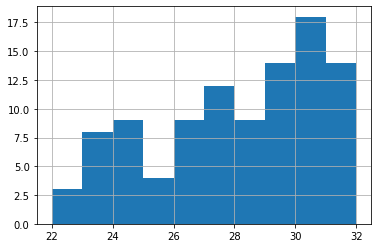

<IPython.core.display.Javascript object>

In [209]:
df_sc_events["num_events_sum_nback_cp"].iloc[0:100].hist()

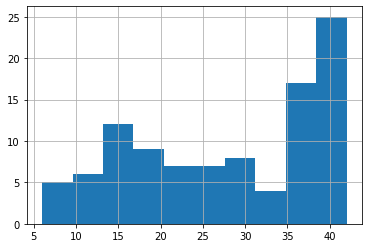

<IPython.core.display.Javascript object>

In [208]:
df_sc_events["num_events_sum_nback_tp"].iloc[0:100].hist()

In [187]:
df_sc_events_cp_throw["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]

0      29.0
1      29.0
2      28.0
3      28.0
4      27.0
       ... 
496     NaN
497     NaN
498     NaN
499     NaN
500     NaN
Name: event_code, Length: 390, dtype: float64

<IPython.core.display.Javascript object>

500

<IPython.core.display.Javascript object>

In [185]:
df_sc_events_cp_throw

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,event_code,event_code_sum_nback,num_events_sum_nback,prop_events_sum_nback,prop_events_nback
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,33.0,33.0,0.33,0.33
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,32.0,32.0,0.32,0.32
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,32.0,32.0,0.32,0.32
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,machm001,machama01,11493,2012.0,2019.0,1,32.0,32.0,0.32,0.32
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,machm001,machama01,11493,2012.0,2019.0,1,31.0,31.0,0.31,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,SL,2019-04-26,86.0,-3.4961,5.1076,Max Scherzer,592518.0,453286.0,strikeout,swinging_strike,...,machm001,machama01,11493,2012.0,2019.0,0,NaN,NaN,NaN,NaN
497,SL,2019-04-24,84.2,-2.5172,5.8355,Felix Hernandez,592518.0,433587.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,NaN,NaN,NaN,NaN
498,SI,2019-04-24,90.3,-2.1757,5.8358,Felix Hernandez,592518.0,433587.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,NaN,NaN,NaN,NaN
499,SI,2019-04-24,88.9,-2.2221,5.8318,Felix Hernandez,592518.0,433587.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [160]:
p_throw = df_sc_events["p_throws"].iloc[0]

<IPython.core.display.Javascript object>

In [166]:
df_sc_events_cp_throw = df_sc_events[df_sc_events["p_throws"] == p_throw]

<IPython.core.display.Javascript object>

In [176]:
df_sc_events_cp_throw.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            490, 491, 492, 494, 495, 496, 497, 498, 499, 500],
           dtype='int64', length=390)

<IPython.core.display.Javascript object>

In [179]:
# df_sc_events_cp_throw["num_events_sum_nback"] =
df_sc_events_cp_throw["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1].iloc[
    0:100
]

0      29.0
1      29.0
2      28.0
3      28.0
4      27.0
       ... 
129    26.0
132    26.0
133    25.0
134    26.0
135    27.0
Name: event_code, Length: 100, dtype: float64

<IPython.core.display.Javascript object>

In [156]:
df_sc_events["p_throws"].iloc[0]

'R'

<IPython.core.display.Javascript object>

In [152]:
df_sc_events[["event_code", "num_events_sum_nback", "prop_events_nback"]]

,event_code,num_events_sum_nback,prop_events_nback
0,1,33.0,0.33
1,1,32.0,0.32
2,0,32.0,0.32
3,1,32.0,0.32
4,1,31.0,0.31
...,...,...,...
496,0,NaN,NaN
497,0,NaN,NaN
498,0,NaN,NaN
499,1,NaN,NaN


<IPython.core.display.Javascript object>

Text(0, 0.5, 'prop_events_nback')

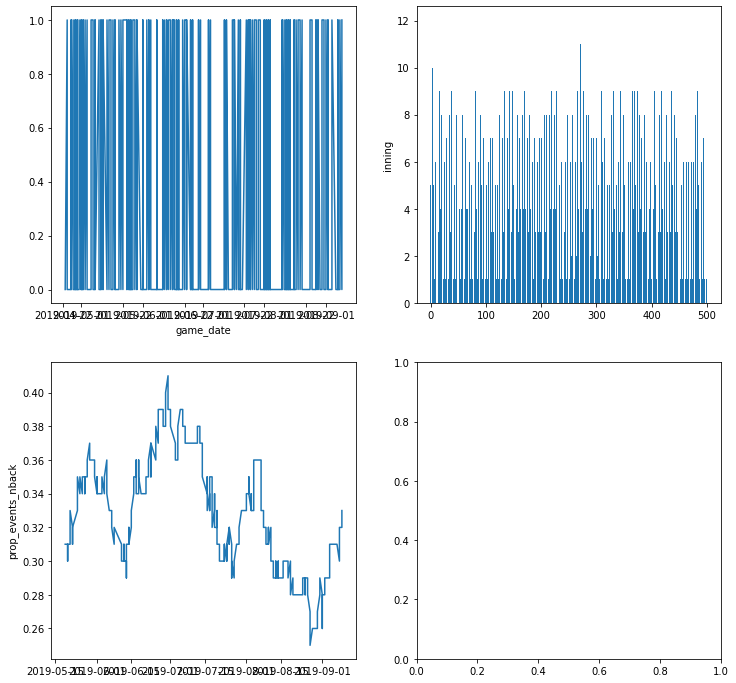

<IPython.core.display.Javascript object>

In [155]:
# Sanity checking that df is in order
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
ax1.plot(df_sc_events["game_date"], df_sc_events["event_code"])
ax1.set_xlabel("game_date")
# ax1.set_xticklabels(df_sc_events["game_date"], rotation=45)

ax2.bar(df_sc_events.index, df_sc_events["inning"])
ax2.set_ylabel("inning")

# Rolling average
ax3.plot(df_sc_events["game_date"], df_sc_events["prop_events_nback"])
ax3.set_ylabel("prop_events_nback")


# ax2.bar(df_sc_events.index, df_sc_events["inning"])
# ax2.set_ylabel("inning")


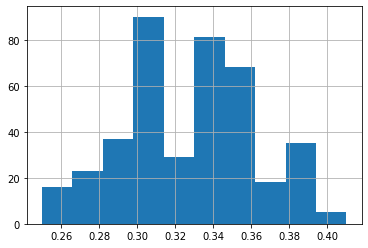

<IPython.core.display.Javascript object>

In [154]:
df_sc_events["prop_events_nback"].hist()

In [113]:
df_sc_events[["game_date", "inning", "event_code", "event_code_sum_nback"]]

,game_date,inning,event_code,event_code_sum_nback
0,2019-09-09,5.0,1,NaN
1,2019-09-09,4.0,1,2.0
2,2019-09-09,1.0,0,2.0
3,2019-09-08,10.0,1,2.0
4,2019-09-08,7.0,1,NaN
...,...,...,...,...
96,2019-08-13,7.0,1,NaN
97,2019-08-13,4.0,0,NaN
98,2019-08-13,2.0,1,NaN
99,2019-08-13,1.0,0,NaN


<IPython.core.display.Javascript object>

In [57]:
df_sc_events["event_code"].head(10)

0    1
1    0
2    1
3    1
4    0
5    0
6    0
7    1
8    0
9    0
Name: event_code, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
# Limit this to events of player's outcome (not caught stealing, foul, etc.)

# Valid for higher probability of predicting 1 identifies better player?

- Do models for each player and look at probabilities of outputting 1


## Input both batters and date

In [977]:
# FUNCTION FOR GETTING STATCAST DATA

# Enter key_mlbam (Manny Machado shown below)
pid_of_interest1 = 592518

# Enter key_mlbam (Maikel Franco, WAR of 0-1)
pid_of_interest2 = 596748

date_of_interest = "'2019-09-09'"  # Note internal single quotes

no_total_ab_events = 1000

# Note: SQL union of two different searches doesn't preserve order
# It's easier to make a dataframe for each player
# https://stackoverflow.com/questions/21181664/sql-server-union-but-keep-order/21181766

# ---------------------------------------------------

<IPython.core.display.Javascript object>

In [1180]:
# Player 1

sql_query = (
    """
(SELECT * FROM statcast 
JOIN player_id ON statcast.batter=player_id.key_mlbam 
WHERE statcast.batter= 
"""
    + str(pid_of_interest1)
    + """
AND statcast.game_date<=
"""
    + str(date_of_interest)
    + """ 
AND statcast.events IS NOT NULL 
ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
LIMIT
"""
    + str(no_total_ab_events)
    + ");"
)

print(sql_query)

df_sc_events1 = pd.read_sql_query(sql_query, con)
df_sc_events1.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df


(SELECT * FROM statcast 
JOIN player_id ON statcast.batter=player_id.key_mlbam 
WHERE statcast.batter= 
592518
AND statcast.game_date<=
'2019-09-09' 
AND statcast.events IS NOT NULL 
ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
LIMIT
1000);


<IPython.core.display.Javascript object>

In [979]:
# FUNCTION FOR GETTING STATCAST DATA - player 2

# Note: SQL union of two different searches doesn't preserve order
# It's easier to make a dataframe for each player
# https://stackoverflow.com/questions/21181664/sql-server-union-but-keep-order/21181766

# ---------------------------------------------------

sql_query = (
    """
(SELECT * FROM statcast 
JOIN player_id ON statcast.batter=player_id.key_mlbam 
WHERE statcast.batter= 
"""
    + str(pid_of_interest2)
    + """
AND statcast.game_date<=
"""
    + str(date_of_interest)
    + """ 
AND statcast.events IS NOT NULL 
ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
LIMIT
"""
    + str(no_total_ab_events)
    + ");"
)

print(sql_query)

df_sc_events2 = pd.read_sql_query(sql_query, con)
df_sc_events2.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df


(SELECT * FROM statcast 
JOIN player_id ON statcast.batter=player_id.key_mlbam 
WHERE statcast.batter= 
596748
AND statcast.game_date<=
'2019-09-09' 
AND statcast.events IS NOT NULL 
ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
LIMIT
1000);


<IPython.core.display.Javascript object>

In [980]:
df_sc_events2.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SL,2019-09-09,82.2,-2.0547,5.2492,Mike Foltynewicz,596748.0,592314.0,strikeout,swinging_strike,...,Standard,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0
1,FT,2019-09-09,94.9,-2.0080,5.4325,Mike Foltynewicz,596748.0,592314.0,field_out,hit_into_play,...,Standard,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0
2,SL,2019-09-08,88.5,-1.3398,6.4312,Jeurys Familia,596748.0,544727.0,field_error,hit_into_play_no_out,...,Standard,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0
3,FF,2019-09-08,94.2,-2.3628,5.5456,Tyler Bashlor,596748.0,641341.0,double,hit_into_play_no_out,...,Standard,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0
4,FT,2019-09-08,90.4,1.3240,6.1355,Luis Avilan,596748.0,501593.0,home_run,hit_into_play_score,...,Standard,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0


<IPython.core.display.Javascript object>

In [898]:
# df_temp = df_sc_events2.copy()
# df_temp = df_temp[df_temp["game_date"].between("2019-04-01", "2019-09-09")]

# df_temp.reset_index(inplace=True)

# # Encode on-base events, including walks
# ob_list = ["walk", "single", "double", "triple", "home_run"]
# df_temp["event_code"] = 0
# df_temp.loc[df["events"].isin(ob_list), "event_code"] = 1

<IPython.core.display.Javascript object>

In [775]:
# df_temp.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,event_code
0,0,SL,2019-09-09,82.2,-2.0547,5.2492,Mike Foltynewicz,596748.0,592314.0,strikeout,...,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0,0
1,1,FT,2019-09-09,94.9,-2.0080,5.4325,Mike Foltynewicz,596748.0,592314.0,field_out,...,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0,0
2,2,SL,2019-09-08,88.5,-1.3398,6.4312,Jeurys Familia,596748.0,544727.0,field_error,...,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0,0
3,3,FF,2019-09-08,94.2,-2.3628,5.5456,Tyler Bashlor,596748.0,641341.0,double,...,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0,1
4,4,FT,2019-09-08,90.4,1.3240,6.1355,Luis Avilan,596748.0,501593.0,home_run,...,Standard,franco,maikel,596748,franm004,francma02,12179,2014.0,2019.0,1


<IPython.core.display.Javascript object>

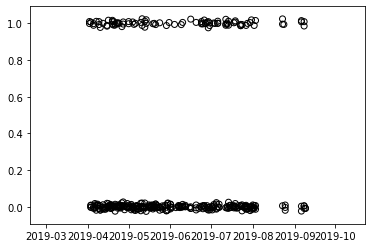

<IPython.core.display.Javascript object>

In [899]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_temp["game_date"],
    df_temp["event_code"] + np.random.normal(0, 0.01, len(df_temp)),
    facecolors="none",
    edgecolors="black",
)

In [900]:
# def get_model_prob(df4model)

# Output probabilities of

<IPython.core.display.Javascript object>

In [985]:
def get_df4model(df, n_back_PA, m_size):
    """
    Function for getting summarized DF
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200
    # -------------------------

    # Reset index so that code below works
    df.reset_index(inplace=True)

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak
    df["num_events_sum_nback"] = (
        df["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]
    )

    # Percent of on-base events (overall)
    df["prop_events_nback"] = df["num_events_sum_nback"] / n_back_PA

    # Percent of on-base events against handedness of pitcher
    for i in df.index:
        p_throws = df["p_throws"].iloc[i]  # Get handedness of pitcher
        df_pt_throw = df[df["p_throws"] == p_throws]
        n_pt_events = df_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
        df.loc[i, "num_events_sum_nback_pt"] = n_pt_events
        df.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]

    df_4model = df[col4model].copy()
    df_4model_overall = df_4model.loc[:m_size]

    return df_4model_overall

<IPython.core.display.Javascript object>

In [986]:
df_sc_events1.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

In [987]:
df4model_p1 = get_df4model(df=df_sc_events1.copy(), n_back_PA=100, m_size=200)

<IPython.core.display.Javascript object>

In [988]:
print(df4model_p1.head())
print(df4model_p1.shape)

   event_code p_throws  prop_events_nback  prop_events_sum_nback_pt
0           1        R               0.33                      0.29
1           1        R               0.32                      0.29
2           0        R               0.32                      0.28
3           1        R               0.32                      0.28
4           1        R               0.31                      0.27
(201, 4)


<IPython.core.display.Javascript object>

In [989]:
df4model_p2 = get_df4model(df=df_sc_events2.copy(), n_back_PA=100, m_size=200)

<IPython.core.display.Javascript object>

In [990]:
print(df4model_p2.head())
print(df4model_p2.shape)

   event_code p_throws  prop_events_nback  prop_events_sum_nback_pt
0           0        R               0.31                      0.29
1           0        R               0.31                      0.29
2           0        R               0.31                      0.29
3           1        R               0.32                      0.30
4           1        L               0.31                      0.26
(201, 4)


<IPython.core.display.Javascript object>

In [991]:
print(pid_of_interest1, pid_of_interest2)

592518 596748


<IPython.core.display.Javascript object>

## EDA

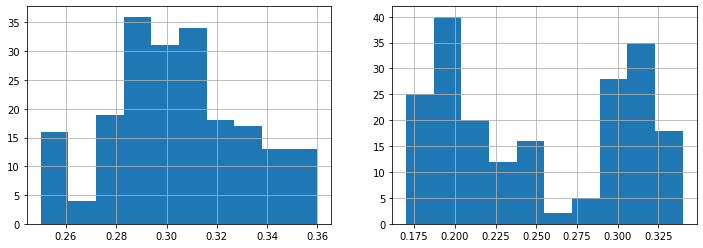

<IPython.core.display.Javascript object>

In [992]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df4model_p1["prop_events_nback"].hist(ax=ax1)
df4model_p2["prop_events_nback"].hist(ax=ax2)

In [993]:
print(
    round(df4model_p1["prop_events_nback"].mean(), 3),
    round(df4model_p2["prop_events_nback"].mean(), 3),
)

0.305 0.25


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Player 2 (overall)')

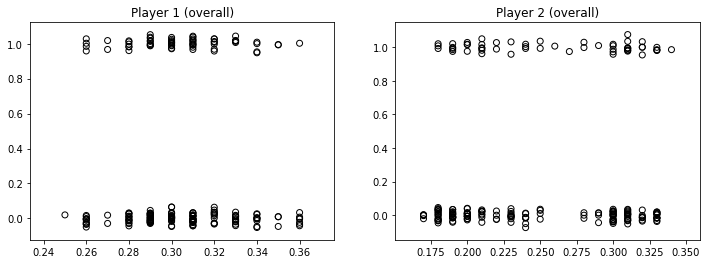

<IPython.core.display.Javascript object>

In [994]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(
    df4model_p1["prop_events_nback"],
    df4model_p1["event_code"] + np.random.normal(0, 0.025, len(df4model_p1)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 1 (overall)")

ax2.scatter(
    df4model_p2["prop_events_nback"],
    df4model_p2["event_code"] + np.random.normal(0, 0.025, len(df4model_p2)),
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("Player 2 (overall)")

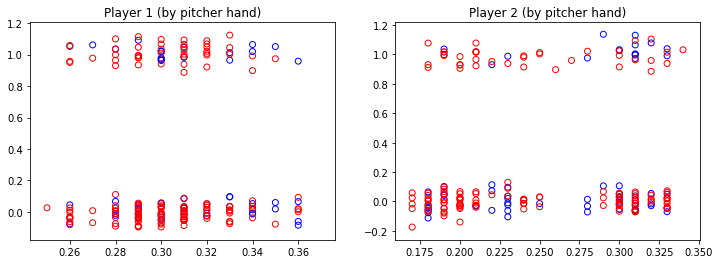

<IPython.core.display.Javascript object>

In [995]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
c_hand_list = ["blue", "red"]

for i, hand in enumerate(["L", "R"]):
    df4model_p1_hand = df4model_p1[df4model_p1["p_throws"] == hand].copy()
    df4model_p2_hand = df4model_p2[df4model_p2["p_throws"] == hand].copy()

    ax1.scatter(
        df4model_p1_hand["prop_events_nback"],
        df4model_p1_hand["event_code"]
        + +np.random.normal(0, 0.05, len(df4model_p1_hand)),
        facecolors="none",
        edgecolors=c_hand_list[i],
    )
    ax1.set_title("Player 1 (by pitcher hand)")

    ax2.scatter(
        df4model_p2_hand["prop_events_nback"],
        df4model_p2_hand["event_code"]
        + np.random.normal(0, 0.05, len(df4model_p2_hand)),
        facecolors="none",
        edgecolors=c_hand_list[i],
    )
    ax2.set_title("Player 2 (by pitcher hand)")

Text(0.5, 1.0, 'Player 2')

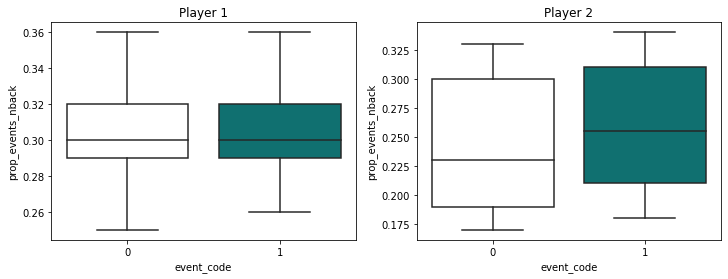

<IPython.core.display.Javascript object>

In [996]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(
    x="event_code",
    y="prop_events_nback",
    data=df4model_p1,
    palette=["w", "teal"],
    order=[0, 1],
    ax=ax1,
)
ax1.set_title("Player 1")

sns.boxplot(
    x="event_code",
    y="prop_events_nback",
    data=df4model_p2,
    palette=["w", "teal"],
    order=[0, 1],
    ax=ax2,
)
ax2.set_title("Player 2")

In [997]:
groupA1_vals = df4model_p1.loc[df4model_p1["event_code"] == 0, "prop_events_nback"]
groupA2_vals = df4model_p1.loc[df4model_p1["event_code"] == 1, "prop_events_nback"]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]

print("Player 1 MW: ", mw_p_A, "Player 1 t-test: ", ttest_p_A)

Player 1 MW:  0.4405279587243318 Player 1 t-test:  0.9847319393233707


<IPython.core.display.Javascript object>

In [998]:
groupA1_vals = df4model_p1.loc[df4model_p2["event_code"] == 0, "prop_events_nback"]
groupA2_vals = df4model_p1.loc[df4model_p2["event_code"] == 1, "prop_events_nback"]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]

print("Player 2 MW: ", mw_p_A, "Player 2 t-test: ", ttest_p_A)

Player 2 MW:  0.40942158467676454 Player 2 t-test:  0.8198983945378358


<IPython.core.display.Javascript object>

## Logistic regression

In [999]:
# FUNCTION TO REPLACE CATEGORICAL INPUT
df4model_p1['p_throws'].replace({'L':0, 'R':1}, inplace=True)
df4model_p2['p_throws'].replace({'L':0, 'R':1}, inplace=True)


<IPython.core.display.Javascript object>

In [1000]:
df4model_p1.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,1,1,0.33,0.29
1,1,1,0.32,0.29
2,0,1,0.32,0.28
3,1,1,0.32,0.28
4,1,1,0.31,0.27


<IPython.core.display.Javascript object>

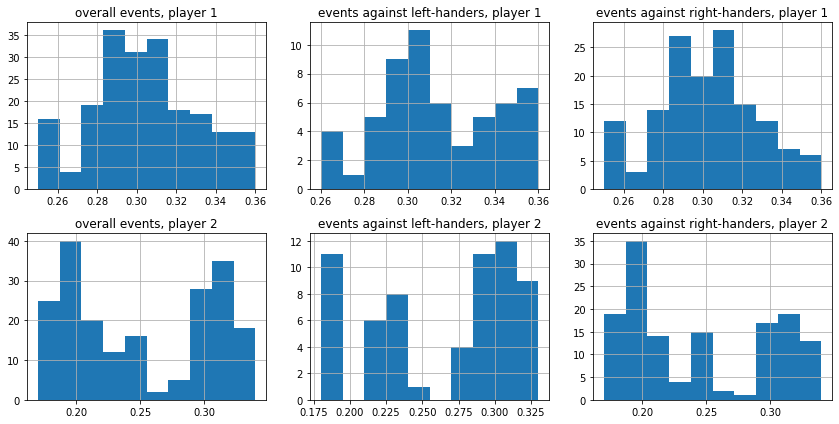

<IPython.core.display.Javascript object>

In [1001]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))

df4model_p1["prop_events_nback"].hist(ax=ax1)
ax1.set_title("overall events, player 1")

df_temp = df4model_p1[df4model_p1["p_throws"] == 0]
df_temp["prop_events_nback"].hist(ax=ax2)
ax2.set_title("events against left-handers, player 1")

df_temp = df4model_p1[df4model_p1["p_throws"] == 1]
df_temp["prop_events_nback"].hist(ax=ax3)
ax3.set_title("events against right-handers, player 1")

df4model_p2["prop_events_nback"].hist(ax=ax4)
ax4.set_title("overall events, player 2")

df_temp = df4model_p2[df4model_p2["p_throws"] == 0]
df_temp["prop_events_nback"].hist(ax=ax5)
ax5.set_title("events against left-handers, player 2")

df_temp = df4model_p2[df4model_p2["p_throws"] == 1]
df_temp["prop_events_nback"].hist(ax=ax6)
ax6.set_title("events against right-handers, player 2")

plt.tight_layout()

In [1002]:
def get_split_data(df4model, testsize):
    y = df4model["event_code"]
    X = df4model.iloc[:, 1::]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    # Scale features based on training data
    std_scale = StandardScaler()
    X_train_scale = std_scale.fit_transform(X_train)

    # Apply scale to test
    X_test_scale = std_scale.transform(X_test)

    return X_train_scale, X_test_scale, y_train, y_test

<IPython.core.display.Javascript object>

In [1003]:
df4model_p2.shape

(201, 4)

<IPython.core.display.Javascript object>

In [1004]:
X_train_scale_p1, X_test_scale_p1, y_train_p1, y_test_p1 = get_split_data(
    df4model_p1, 0.3
)
X_train_scale_p2, X_test_scale_p2, y_train_p2, y_test_p2 = get_split_data(
    df4model_p2, 0.3
)

<IPython.core.display.Javascript object>

In [1005]:
print(X_train_p1.shape, X_test_p1.shape, y_train_p1.shape, y_test_p1.shape)
print(X_train_p2.shape, X_test_p2.shape, y_train_p2.shape, y_test_p2.shape)

(140, 3) (61, 3) (140,) (61,)
(140, 3) (61, 3) (140,) (61,)


<IPython.core.display.Javascript object>

In [1006]:
log_reg_p1 = LogisticRegression()
log_reg_p1.fit(X_train_p1, y_train_p1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [1007]:
y_pred_p1 = log_reg_p1.predict(X_test_p1)
y_predprob_p1 = log_reg_p1.predict_proba(X_test_p1)[:, 1]

<IPython.core.display.Javascript object>

In [1008]:
df_eval_p1 = pd.DataFrame(
    {"test": y_test_p1, "pred": y_pred_p1, "predprob": y_predprob_p1}
)
df_eval_p1.head()

,test,pred,predprob
40,1,0,0.279643
141,0,0,0.296987
33,0,0,0.278889
91,1,0,0.299045
13,0,0,0.296955


<IPython.core.display.Javascript object>

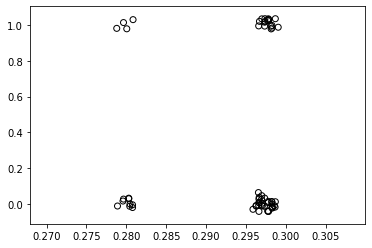

<IPython.core.display.Javascript object>

In [924]:
f, ax1 = plt.subplots()

#
ax1.scatter(
    df_eval_p1["predprob"],
    df_eval_p1["test"] + np.random.normal(0, 0.025, len(df_eval_p1)),
    facecolors="none",
    edgecolors="black",
)

In [1009]:
log_reg_p1.coef_

array([[ 0.0848606 , -0.01561065, -0.1873275 ]])

<IPython.core.display.Javascript object>

In [1010]:
print(
    "low prob, 0: ", ((df_eval_p1["predprob"] < 0.29) & (df_eval_p1["test"] == 0)).sum()
)
print(
    "low prob, 1: ", ((df_eval_p1["predprob"] < 0.29) & (df_eval_p1["test"] == 1)).sum()
)
print(
    "high prob, 0: ",
    ((df_eval_p1["predprob"] > 0.29) & (df_eval_p1["test"] == 0)).sum(),
)
print(
    "high prob, 1: ",
    ((df_eval_p1["predprob"] > 0.29) & (df_eval_p1["test"] == 1)).sum(),
)

low prob, 0:  9
low prob, 1:  4
high prob, 0:  31
high prob, 1:  17


<IPython.core.display.Javascript object>

In [1011]:
# The number of right-handed pitchers matches the "high probability"
X_test_p1["p_throws"].sum()

48

<IPython.core.display.Javascript object>

In [1012]:
log_reg_p2 = LogisticRegression()
log_reg_p2.fit(X_train_p2, y_train_p2)

y_pred_p2 = log_reg_p2.predict(X_test_p2)
y_predprob_p2 = log_reg_p2.predict_proba(X_test_p2)[:, 1]

<IPython.core.display.Javascript object>

In [1013]:
df_eval_p2 = pd.DataFrame(
    {"test": y_test_p2, "pred": y_pred_p2, "predprob": y_predprob_p2}
)
df_eval_p2.head()

,test,pred,predprob
40,0,0,0.225441
141,0,0,0.224694
33,1,0,0.221881
91,1,0,0.229042
13,0,0,0.231885


<IPython.core.display.Javascript object>

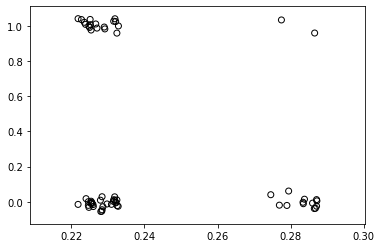

<IPython.core.display.Javascript object>

In [1014]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_eval_p2["predprob"],
    df_eval_p2["test"] + np.random.normal(0, 0.025, len(df_eval_p2)),
    facecolors="none",
    edgecolors="black",
)

In [1015]:
log_reg_p2.coef_

array([[-0.28509659, -0.34176485, -0.19256008]])

<IPython.core.display.Javascript object>

## Output for new case

In [1019]:
input_new_val = [1, 0.32, 0.32]
input_new_val_array = [input_new_val] + [input_new_val]

<IPython.core.display.Javascript object>

In [1020]:
log_reg_p1.predict_proba(input_new_val_array)[:, 1]

array([0.29786787, 0.29786787])

<IPython.core.display.Javascript object>

In [1021]:
log_reg_p2.predict_proba(input_new_val_array)[:, 1]

array([0.22765136, 0.22765136])

<IPython.core.display.Javascript object>

# Add pitcher features, at-bat level

In [958]:
# This will capture starting pitcher most of the time
# Not completely right (somoene could start but leave game before hitter's at-bat)
# but will leave this for validation

# INPUT DATE AND DF OF PITCHER

date_of_interest = date_of_interest
df4_bp_match = df_sc_events1.copy()

# bool_pitcher = df_sc_events1["game_date"] == date_of_interest
# pid_opp_pitcher = df4_bp_match.loc[bool_pitcher, "pitcher"].iloc[-1]

<IPython.core.display.Javascript object>

In [959]:
#print(pid_opp_pitcher)

543294.0


<IPython.core.display.Javascript object>

In [1248]:
df_sc_events1_temp = df_sc_events1.iloc[0:5, :].copy()

<IPython.core.display.Javascript object>

In [1249]:
df_sc_events1_temp

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

## Add pitcher info

In [1250]:
df_sc_events1_temp.shape

(5, 97)

<IPython.core.display.Javascript object>

In [1251]:
def get_df4sc_info_opp_pitcher(pitcher_id, date):

    # (Save info for doing pitcher level)
    # Estimated no. pitches in a season - 34 starts x 100 pitches

    no_ab = 500

    # Getting all the pitches BEFORE facing the batter (< game date)

    sql_query = (
        """
    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    """
        + str(pitcher_id)
        + """
    AND statcast.game_date<
    """
        + str(date_of_interest)
        + """ 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    """
        + str(no_ab)
        + ");"
    )

    print(sql_query)

    df_sc_pitcher = pd.read_sql_query(sql_query, con)
    df_sc_pitcher.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

    # print("head: ", df_sc_pitcher.head())

    return df_sc_pitcher

<IPython.core.display.Javascript object>

In [1185]:
# df_temp = get_df4sc_info_opp_pitcher(df_sc_events1, date2stop)
# df_temp.head()


    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    543294.0
    AND statcast.game_date<
    '2019-09-09' 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    500);


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,CH,2019-09-02,78.0,-2.3667,6.1277,Kyle Hendricks,572122.0,543294.0,field_out,hit_into_play,...,Infield shift,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
1,FF,2019-09-02,86.0,-2.4230,5.9470,Kyle Hendricks,641584.0,543294.0,field_out,hit_into_play,...,Standard,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
2,FF,2019-09-02,85.6,-2.4557,6.0064,Kyle Hendricks,605480.0,543294.0,field_out,hit_into_play,...,Standard,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
3,CH,2019-09-02,76.9,-2.4274,6.0741,Kyle Hendricks,656954.0,543294.0,strikeout,swinging_strike,...,Standard,Strategic,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
4,CU,2019-09-02,71.6,-2.3022,6.0875,Kyle Hendricks,623323.0,543294.0,strikeout,swinging_strike,...,Standard,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0


<IPython.core.display.Javascript object>

In [1096]:
# Get pitch characteristics - lower priority

# fastball velocity, fastball proportion, breaking ball velocity
# df_sc_pitcher.groupby("pitch_type")["release_speed"].mean()

# df_sc_pitcher.groupby("pitch_type")["release_speed"].mean()

<IPython.core.display.Javascript object>

In [1240]:
def get_series4model_4pitcher_for_ab(df, n_back_PA):
    """
    Function for getting summarized series for that pitcher
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200

    # -------------------------

    # Reset index so that code below works
    # df.reset_index(inplace=True)

    df = df.iloc[0 : n_back_PA + 5, :].copy()

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak

    s_for_summary = pd.Series()

    # Total number of events
    s_for_summary["num_events_sum_nback_bs"] = df["event_code"].iloc[0:n_back_PA].sum()
    # Percent of on-base events (overall)
    s_for_summary["prop_events_nback_bs"] = (
        s_for_summary["num_events_sum_nback_bs"] / n_back_PA
    )

    # Percent of on-base events against handedness of batter
    # Tweaked code from old function, just need first row
    for i_stand in ["L", "R"]:
        df_b_stand = df[df["stand"] == i_stand]
        n_bat_events = df_b_stand["event_code"].iloc[0:n_back_PA].sum()
        s_for_summary["num_events_sum_nback_bs" + "_" + i_stand] = n_bat_events
        s_for_summary["prop_events_sum_nback_bs" + "_" + i_stand] = (
            n_bat_events / n_back_PA
        )

    return s_for_summary

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1252]:
col2add2df = ([
    "num_events_sum_nback_bs",
    "prop_events_nback_bs",
    "num_events_sum_nback_bs_L",
    "prop_events_sum_nback_bs_L",
    "num_events_sum_nback_bs_R",
    "prop_events_sum_nback_bs_R",
])

for col in col2add2df:
    df_sc_events1_temp[col] = None

for i, pitcher in enumerate(df_sc_events1_temp["pitcher"]):
    
    date2stop = df_sc_events1_temp["game_date"].iloc[i]
    if i == 0:
        pid_opp_in_mem = pitcher
        print(i, "starting pitcher list: ", pitcher)
        
        # Get data from SQL        
        df_p_info4date = get_df4sc_info_opp_pitcher(pid_opp_in_mem, date2stop)
        p_summary = get_series4model_4pitcher_for_ab(df_p_info4date, 100)
        
        # Add series to df
        df_sc_events1_temp.loc[i, col2add2df] = p_summary
        
    elif (pitcher == pid_opp_in_mem) & (i > 0):
        print(i, "same pitcher: ", pitcher)
        pid_opp_in_mem = pitcher
        
        # Add series to df
        df_sc_events1_temp.loc[i, col2add2df] = p_summary
        
    else:
        print(i, "new pitcher: from ", pid_opp_in_mem, "to ", pitcher)
        pid_opp_in_mem = pitcher
        
        # SQL entry
        # Get data from SQL        
        df_p_info4date = get_df4sc_info_opp_pitcher(pid_opp_in_mem, date2stop)
        p_summary = get_series4model_4pitcher_for_ab(df_p_info4date, 100)
        
        # Add series to df
        df_sc_events1_temp.loc[i, col2add2df] = p_summary


0 starting pitcher list:  543294.0

    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    543294.0
    AND statcast.game_date<
    '2019-09-09' 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    500);
1 same pitcher:  543294.0
2 same pitcher:  543294.0
3 new pitcher: from  543294.0 to  622786.0

    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    622786.0
    AND statcast.game_date<
    '2019-09-09' 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    500);
4 new pitcher: from  622786.0 to  543766.0

    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    543766.0
    AND statcast.game_date<
    '2019-09-09' 
    AND statcast.events IS NOT NULL 
    ORDER BY s

<IPython.core.display.Javascript object>

In [1253]:
df_sc_events1_temp.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,num_events_sum_nback_bs,prop_events_nback_bs,num_events_sum_nback_bs_L,prop_events_sum_nback_bs_L,num_events_sum_nback_bs_R,prop_events_sum_nback_bs_R
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machama01,11493,2012.0,2019.0,26,0.26,14,0.14,14,0.14
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machama01,11493,2012.0,2019.0,26,0.26,14,0.14,14,0.14
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,machama01,11493,2012.0,2019.0,26,0.26,14,0.14,14,0.14
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,machama01,11493,2012.0,2019.0,36,0.36,22,0.22,17,0.17
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,machama01,11493,2012.0,2019.0,35,0.35,9,0.09,26,0.26


<IPython.core.display.Javascript object>

# Pitcher features of pitch level

# Is coefficient of player predictive?

- Combine DFs of A and B
- Just use A and B (with feature encoding) for the input with inputs
